In [574]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sys import getsizeof
from numba import njit

In [575]:
feature_id = 1
DELTA_MZ = 1.003355  # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [576]:
DA_MIN = 100
DA_MAX = 4000
charge = 1

In [577]:
feature_raw_ms2_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/feature-{}-ms2-raw-points.pkl'.format(feature_id))
feature_raw_ms2_df.sort_values(by=['mz'], ascending=True, inplace=True)
feature_raw_ms2_df['decharged_mass'] = (feature_raw_ms2_df.mz + PROTON_MASS) * charge
feature_raw_ms2_df['normalised_intensity'] = feature_raw_ms2_df.intensity / feature_raw_ms2_df.intensity.max()

In [578]:
feature_raw_ms2_df.head()

,frame_id,mz,intensity,decharged_mass,normalised_intensity
0,27938,133.596214,9,134.603514,0.068182
1,27938,180.467447,9,181.474747,0.068182
2,27938,213.418260,9,214.425560,0.068182
3,27938,266.156364,9,267.163664,0.068182
4,27938,268.404245,9,269.411545,0.068182


In [579]:
len(feature_raw_ms2_df)

215

In [580]:
# generate a charge-aware mask of mass defect windows
bin_edges_l = []
for nominal_mass in np.arange(start=DA_MIN, stop=DA_MAX, step=1/charge):
    proton_mass_adjustment = (charge - 1) * PROTON_MASS
    mass_centre = (nominal_mass + proton_mass_adjustment) * 1.00048  # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184890/
    width = (0.19 + (0.0001 * nominal_mass)) / charge
    lower_mass = mass_centre - (width / 2)
    upper_mass = mass_centre + (width / 2)
    bin_edges_l.append(lower_mass)
    bin_edges_l.append(upper_mass)
bins = np.asarray(bin_edges_l)

In [581]:
bins[:20]

array([ 99.948  , 100.148  , 100.94843, 101.14853, 101.94886, 102.14906,
       102.94929, 103.14959, 103.94972, 104.15012, 104.95015, 105.15065,
       105.95058, 106.15118, 106.95101, 107.15171, 107.95144, 108.15224,
       108.95187, 109.15277])

In [582]:
np.digitize(99.95, bins)

1

In [583]:
decharged_mass_a = feature_raw_ms2_df.decharged_mass.to_numpy()
mz_a = feature_raw_ms2_df.mz.to_numpy()
intensity_a = feature_raw_ms2_df.intensity.to_numpy()
available_a = np.full((len(mz_a)), True)  # the raw points not yet assigned to a peak

In [584]:
digitised_mass = np.digitize(decharged_mass_a[available_a == True], bins)  # an odd index means the point is inside a mass defect window
digitised_mass

array([  70,  164,  230,  335,  340,  384,  385,  391,  409,  441,  453,
        459,  511,  522,  525,  525,  553,  597,  603,  607,  609,  619,
        626,  627,  629,  633,  637,  651,  661,  665,  665,  669,  677,
        709,  719,  734,  737,  757,  773,  782,  801,  801,  811,  817,
        825,  825,  827,  828,  845,  847,  861,  861,  863,  863,  865,
        867,  867,  883,  883,  883,  885,  885,  887,  887,  887,  891,
        903,  905,  911,  918,  951,  955,  960,  965,  979,  987, 1001,
       1019, 1021, 1033, 1033, 1037, 1051, 1053, 1086, 1087, 1088, 1089,
       1105, 1133, 1141, 1143, 1147, 1149, 1194, 1202, 1203, 1219, 1231,
       1258, 1302, 1302, 1318, 1341, 1353, 1371, 1373, 1373, 1375, 1375,
       1375, 1391, 1425, 1453, 1511, 1511, 1511, 1513, 1513, 1513, 1513,
       1513, 1513, 1515, 1515, 1515, 1515, 1515, 1515, 1515, 1515, 1515,
       1515, 1515, 1515, 1517, 1517, 1517, 1517, 1517, 1517, 1517, 1517,
       1517, 1518, 1522, 1581, 1645, 1661, 1699, 17

In [585]:
# consecutive odd indexes means consecutive windows, suggesting a series of isotopic peaks

In [586]:
# remove all the even indexes - the odd indexes are the mass defect windows
mass_defect_window_indexes = digitised_mass[(digitised_mass % 2) == 1]
mass_defect_window_indexes

array([ 335,  385,  391,  409,  441,  453,  459,  511,  525,  525,  553,
        597,  603,  607,  609,  619,  627,  629,  633,  637,  651,  661,
        665,  665,  669,  677,  709,  719,  737,  757,  773,  801,  801,
        811,  817,  825,  825,  827,  845,  847,  861,  861,  863,  863,
        865,  867,  867,  883,  883,  883,  885,  885,  887,  887,  887,
        891,  903,  905,  911,  951,  955,  965,  979,  987, 1001, 1019,
       1021, 1033, 1033, 1037, 1051, 1053, 1087, 1089, 1105, 1133, 1141,
       1143, 1147, 1149, 1203, 1219, 1231, 1341, 1353, 1371, 1373, 1373,
       1375, 1375, 1375, 1391, 1425, 1453, 1511, 1511, 1511, 1513, 1513,
       1513, 1513, 1513, 1513, 1515, 1515, 1515, 1515, 1515, 1515, 1515,
       1515, 1515, 1515, 1515, 1515, 1517, 1517, 1517, 1517, 1517, 1517,
       1517, 1517, 1517, 1581, 1645, 1661, 1699, 1707, 1739, 1739, 1739,
       1741, 1741, 1743, 1745, 1745, 1883, 1899, 1913, 1933, 1939, 1939,
       1941, 1941, 1941, 1941, 1941, 1943, 1943, 19

In [587]:
# remove the duplicates
unique_mass_defect_window_indexes = np.unique(mass_defect_window_indexes)
unique_mass_defect_window_indexes

array([ 335,  385,  391,  409,  441,  453,  459,  511,  525,  553,  597,
        603,  607,  609,  619,  627,  629,  633,  637,  651,  661,  665,
        669,  677,  709,  719,  737,  757,  773,  801,  811,  817,  825,
        827,  845,  847,  861,  863,  865,  867,  883,  885,  887,  891,
        903,  905,  911,  951,  955,  965,  979,  987, 1001, 1019, 1021,
       1033, 1037, 1051, 1053, 1087, 1089, 1105, 1133, 1141, 1143, 1147,
       1149, 1203, 1219, 1231, 1341, 1353, 1371, 1373, 1375, 1391, 1425,
       1453, 1511, 1513, 1515, 1517, 1581, 1645, 1661, 1699, 1707, 1739,
       1741, 1743, 1745, 1883, 1899, 1913, 1933, 1939, 1941, 1943, 1945,
       1947, 1949, 2013, 2055, 2073, 2123, 2163, 2165, 2167, 2199, 2201,
       2203, 2205, 2267, 2271, 2319, 2369, 2403, 2521, 2567, 2967])

In [588]:
# the elements of unique_mass_defect_window_indexes are the bin indexes (mass defect windows) that have signal present

In [589]:
# find where the windows are consecutive
condition = (np.diff(unique_mass_defect_window_indexes) == 2)
condition

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False])

In [590]:
chunk_sizes = np.diff(np.where(np.concatenate(([condition[0]],
                                     condition[:-1] != condition[1:],
                                     [True])))[0])[::2]
chunk_sizes

array([1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 3, 3, 5, 2, 3])

In [591]:
consecutive_window_indexes = np.where(condition == True)[0]
consecutive_window_indexes

array([ 12,  15,  32,  34,  36,  37,  38,  40,  41,  44,  53,  57,  59,
        63,  65,  72,  73,  78,  79,  80,  87,  88,  89,  95,  96,  97,
        98,  99, 105, 106, 108, 109, 110])

In [592]:
peaks_l = []
expected_peak_spacing = DELTA_MZ / charge
for series_idx in range(len(chunk_sizes)):
    number_of_windows = chunk_sizes[series_idx]
    start_idx = chunk_sizes[:series_idx].sum()
    index_list = consecutive_window_indexes[start_idx:start_idx+number_of_windows].tolist()
    index_list.append(index_list[-1]+1)
    print("isotope series {} ({} peaks):".format(series_idx+1, number_of_windows+1))
    mz_l = []
    int_l = []
    for peak_idx,i in enumerate(index_list):
        lower_mass = round(bins[unique_mass_defect_window_indexes[i]-1],4)
        upper_mass = round(bins[unique_mass_defect_window_indexes[i]],4)
        print("mass defect window [{}]: {}-{} Da".format(unique_mass_defect_window_indexes[i], lower_mass, upper_mass))
        # get the raw points allocated to this bin
        peak_indexes = np.where(digitised_mass == unique_mass_defect_window_indexes[i])[0]
        print("\tpeak mass {}".format(np.round(decharged_mass_a[peak_indexes],4)))
        print("\tpeak m/z {}".format(np.round(mz_a[peak_indexes],4)))
        mz_centroid = np.average(mz_a[peak_indexes], weights=intensity_a[peak_indexes])
        intensity = np.sum(intensity_a[peak_indexes])
        mz_l.append(mz_centroid)
        int_l.append(intensity)
        print("\tpeak centroid {} m/z, {}".format(np.round(mz_centroid,4), intensity))
        available_a[peak_indexes] = False
        peaks_l.append((series_idx, peak_idx, mz_centroid, intensity))
    # de-isotope the peaks
    peaks_mz_a = np.array(mz_l)
    peaks_int_a = np.array(int_l)
    for i in range(len(peaks_mz_a)):
        peaks_mz_a[i] = peaks_mz_a[i] - (i * expected_peak_spacing)
    print("de-isotoped m/z {}".format(np.round(peaks_mz_a,4)))
    deisotoped_mz = np.average(peaks_mz_a, weights=peaks_int_a)
    print("de-isotoped m/z centroid {}".format(np.round(deisotoped_mz,4)))
    monoisotopic_mass = (deisotoped_mz - PROTON_MASS) * charge
    print("monoisotopic mass {} Da".format(np.round(monoisotopic_mass,4)))
    print()
    

isotope series 1 (2 peaks):
mass defect window [607]: 403.0783-403.3086 Da
	peak mass [403.2262]
	peak m/z [402.2189]
	peak centroid 402.2189 m/z, 10
mass defect window [609]: 404.0787-404.3091 Da
	peak mass [404.2008]
	peak m/z [403.1935]
	peak centroid 403.1935 m/z, 23
de-isotoped m/z [402.2189 402.1902]
de-isotoped m/z centroid 402.1989
monoisotopic mass 401.1916 Da

isotope series 2 (2 peaks):
mass defect window [627]: 413.0826-413.3139 Da
	peak mass [413.2652]
	peak m/z [412.2579]
	peak centroid 412.2579 m/z, 27
mass defect window [629]: 414.083-414.3144 Da
	peak mass [414.2615]
	peak m/z [413.2542]
	peak centroid 413.2542 m/z, 114
de-isotoped m/z [412.2579 412.2509]
de-isotoped m/z centroid 412.2522
monoisotopic mass 411.2449 Da

isotope series 3 (2 peaks):
mass defect window [825]: 512.1252-512.3664 Da
	peak mass [512.2568 512.2604]
	peak m/z [511.2495 511.2531]
	peak centroid 511.2516 m/z, 99
mass defect window [827]: 513.1256-513.3669 Da
	peak mass [513.2627]
	peak m/z [512.25

In [596]:
# peaks remaining after charge-2 and charge-1 processing are considered to be orphaned isotopes, truncated by 
# the original isolation window, that we still want to carry through.

# need to group the remaining peaks by mass defect window, centroid the peaks in a window, and add them to our 
# list of peaks
mass_defect_window_indexes


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True, False,  True, False,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [593]:
peaks_df = pd.DataFrame(peaks_l, columns=['series','peak','mz','intensity'])
peaks_df['normalised_intensity'] = peaks_df.intensity / peaks_df.intensity.max()

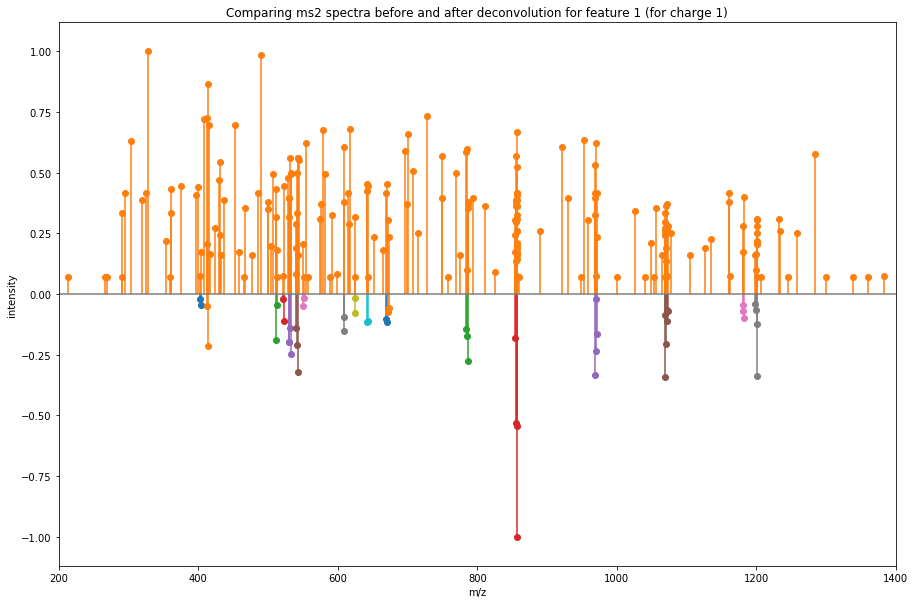

In [594]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(feature_raw_ms2_df.mz, feature_raw_ms2_df.normalised_intensity, label='before deconvolution', use_line_collection=True)
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

groups = peaks_df.groupby('series')
for i, (name, group) in enumerate(groups):
    markerline, stemlines, baseline = ax.stem(group.mz, -group.normalised_intensity, label=name, use_line_collection=True)
    plt.setp(markerline, 'color', colors[i % len(colors)])
    plt.setp(stemlines, 'color', colors[i % len(colors)])
    plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(10)
f.set_figwidth(15)
ax.set_xlim((200,1400))
plt.margins(0.06)
# plt.legend(loc='best')
plt.title('Comparing ms2 spectra before and after deconvolution for feature {} (for charge {})'.format(feature_id, charge))
plt.show()